# 03 — Clustering Exploration

Interactive exploration of temporal clustering results:
- Silhouette analysis and method comparison
- Cluster center visualization
- Geographic patterns in cluster assignments
- Deep-dive into individual clusters

**Prerequisites:** Run `make cluster` first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.cluster.hierarchy import dendrogram

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

import sys
sys.path.insert(0, str(Path.cwd().parent))
from src.config import DATA_PROCESSED, RESULTS_DIR, extract_borough

## 1. Load Results

In [2]:
# Cluster assignments
dist_assign = pd.read_parquet(RESULTS_DIR / 'cluster_assignments_district.parquet')
sect_assign = pd.read_parquet(RESULTS_DIR / 'cluster_assignments_section.parquet')

# Metrics
metrics = pd.read_csv(RESULTS_DIR / 'cluster_metrics.csv')

# Feature matrices
X_dist = np.load(RESULTS_DIR / 'feature_matrix_district.npy')
ids_dist = pd.read_csv(RESULTS_DIR / 'feature_ids_district.csv').iloc[:, 0].tolist()

print(f"District assignments: {dist_assign.shape}")
print(f"Section assignments: {sect_assign.shape}")
print(f"\nMetrics:")
metrics

District assignments: (59, 5)
Section assignments: (221, 5)

Metrics:


,silhouette,calinski_harabasz,davies_bouldin,n_clusters,best_k,method,level,eps,n_noise
0,0.028473,1.526111,3.884257,2,2.0,KMeans,district,NaN,NaN
1,0.009938,1.509827,6.137705,2,2.0,DTW_KMeans,district,NaN,NaN
2,0.016315,1.455593,3.260071,7,7.0,Hierarchical,district,NaN,NaN
3,NaN,NaN,NaN,1,NaN,DBSCAN,district,30.065358,44.0
4,0.005372,1.846638,10.383883,2,2.0,KMeans,section,NaN,NaN
5,0.000180,1.049933,14.256694,2,2.0,DTW_KMeans,section,NaN,NaN
6,0.003691,1.485823,4.724738,15,15.0,Hierarchical,section,NaN,NaN
7,0.004433,1.335542,3.152317,6,NaN,DBSCAN,section,32.013756,137.0


## 2. Method Comparison

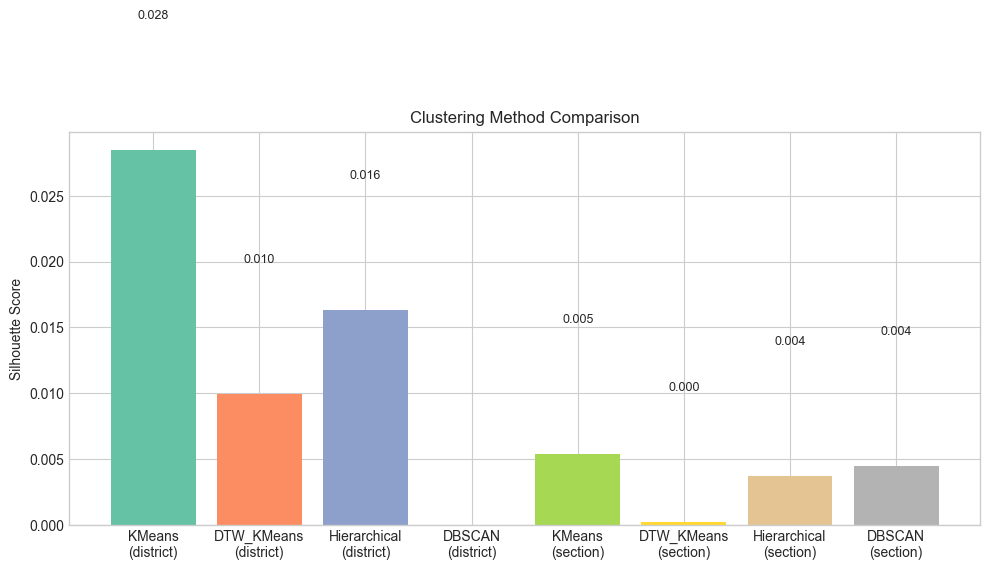

In [3]:
# Silhouette scores side by side
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics))
bars = ax.bar(x, metrics['silhouette'], color=sns.color_palette('Set2', len(metrics)))

labels = [f"{row['method']}\n({row['level']})" for _, row in metrics.iterrows()]
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Silhouette Score')
ax.set_title('Clustering Method Comparison')

for bar, val in zip(bars, metrics['silhouette']):
    if not np.isnan(val):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

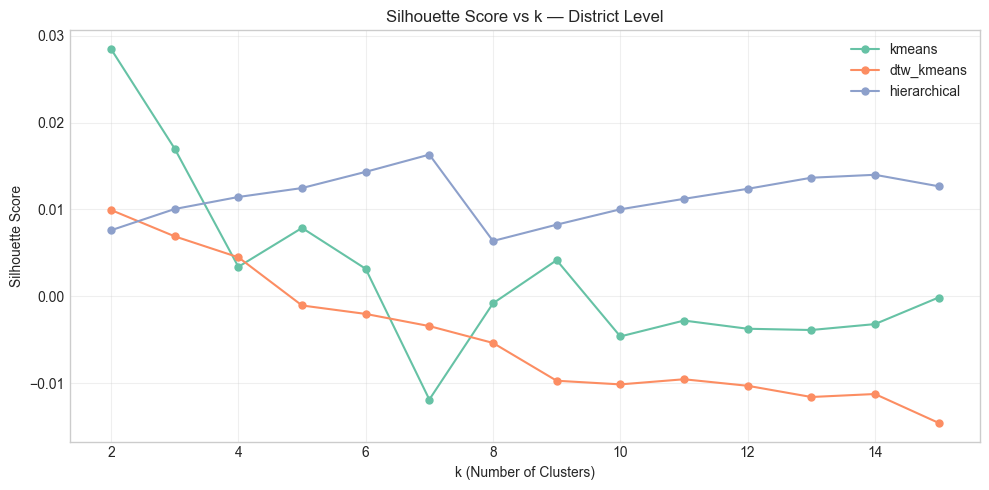

In [4]:
# Silhouette vs k curves
sil_files = list(RESULTS_DIR.glob('silhouette_district_*.csv'))

fig, ax = plt.subplots(figsize=(10, 5))
for f in sil_files:
    data = pd.read_csv(f)
    method = data['method'].iloc[0] if 'method' in data.columns else f.stem
    ax.plot(data['k'], data['silhouette'], marker='o', markersize=5, label=method)

ax.set_xlabel('k (Number of Clusters)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs k — District Level')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Cluster Centers & Members

/var/folders/hq/lzl21s154sjdtgsp2dpr41y80000gp/T/ipykernel_45534/1064118411.py:20: RuntimeWarning: Mean of empty slice.
  ax.plot(members.mean(axis=0), color='darkred', linewidth=2.5)
/Users/nijjohnson/Projects/time-series-analysis-nyc-waste/.venv/lib/python3.14/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


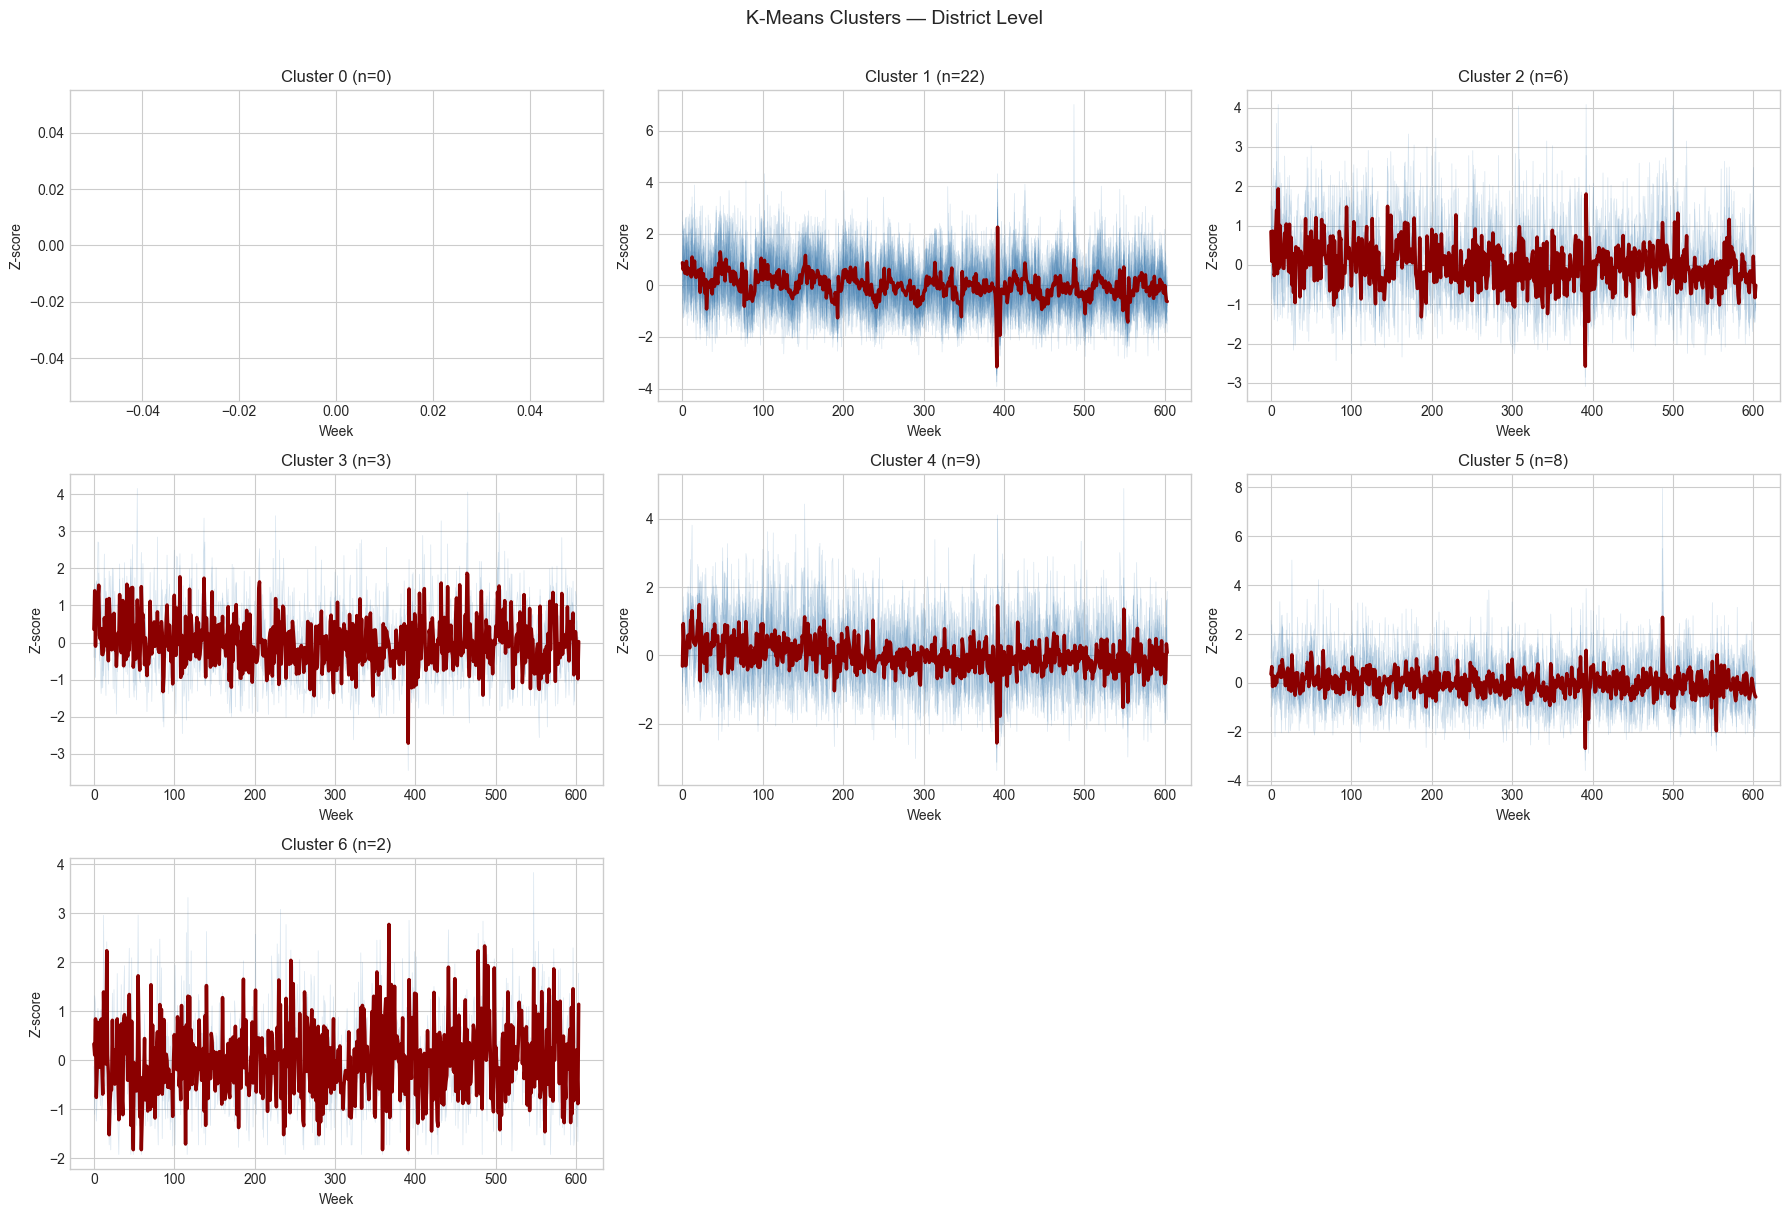

In [11]:
# K-Means cluster centers with member trajectories
#labels = dist_assign['cluster_kmeans'].values
labels = dist_assign['cluster_hierarchical'].values
n_clusters = len(set(labels))

n_cols = min(3, n_clusters)
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = np.atleast_2d(axes)

for k in range(n_clusters):
    row, col = divmod(k, n_cols)
    ax = axes[row, col]
    mask = labels == k
    members = X_dist[mask]

    for ts in members:
        ax.plot(ts, color='steelblue', alpha=0.2, linewidth=0.5)
    ax.plot(members.mean(axis=0), color='darkred', linewidth=2.5)
    
    member_names = [ids_dist[i] for i in np.where(mask)[0]]
    ax.set_title(f'Cluster {k} (n={mask.sum()})')
    ax.set_xlabel('Week')
    ax.set_ylabel('Z-score')

for k in range(n_clusters, n_rows * n_cols):
    row, col = divmod(k, n_cols)
    axes[row, col].set_visible(False)

plt.suptitle('K-Means Clusters — District Level', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

## 4. Cluster Membership

In [6]:
# Which districts are in each cluster?
dist_assign['borough'] = dist_assign['District_Code'].apply(extract_borough)

for k in sorted(dist_assign['cluster_kmeans'].unique()):
    members = dist_assign[dist_assign['cluster_kmeans'] == k]
    print(f"\nCluster {k} ({len(members)} districts):")
    for borough in sorted(members['borough'].unique()):
        codes = members[members['borough'] == borough]['District_Code'].tolist()
        print(f"  {borough}: {', '.join(codes)}")


Cluster 0 (7 districts):
  Bronx: BXW03, BXW04, BXW07
  Manhattan: MN01, MN03, MN04, MN07

Cluster 1 (52 districts):
  Bronx: BXE06, BXE09, BXE10, BXE11, BXE12, BXW01, BXW02, BXW05, BXW08
  Brooklyn: BKN01, BKN02, BKN03, BKN04, BKN05, BKN08, BKSE09, BKSE13, BKSE14, BKSE15, BKSE16, BKSE17, BKSE18, BKSW06, BKSW07, BKSW10, BKSW11, BKSW12
  Manhattan: MN02, MN05, MN06, MN08, MN09, MN10, MN11, MN12
  Queens: QE07, QE08, QE10, QE11, QE12, QE13, QE14, QW01, QW02, QW03, QW04, QW05, QW06, QW09
  Staten Island: SI01, SI02, SI03


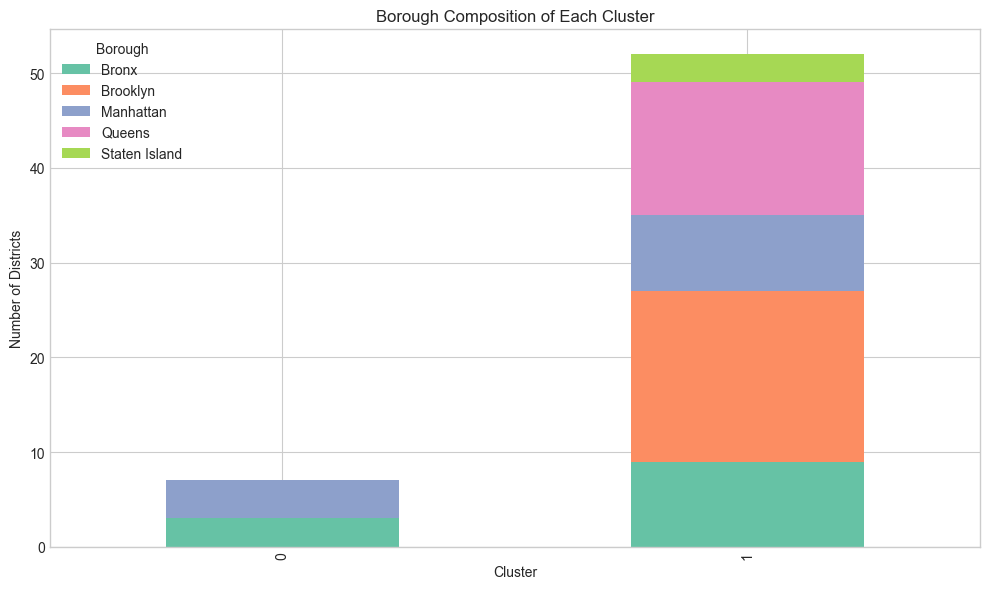

In [7]:
# Cross-tabulation: cluster vs borough
ct = pd.crosstab(dist_assign['cluster_kmeans'], dist_assign['borough'])

fig, ax = plt.subplots(figsize=(10, 6))
ct.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Districts')
ax.set_title('Borough Composition of Each Cluster')
ax.legend(title='Borough')
plt.tight_layout()
plt.show()

## 5. Dendrogram

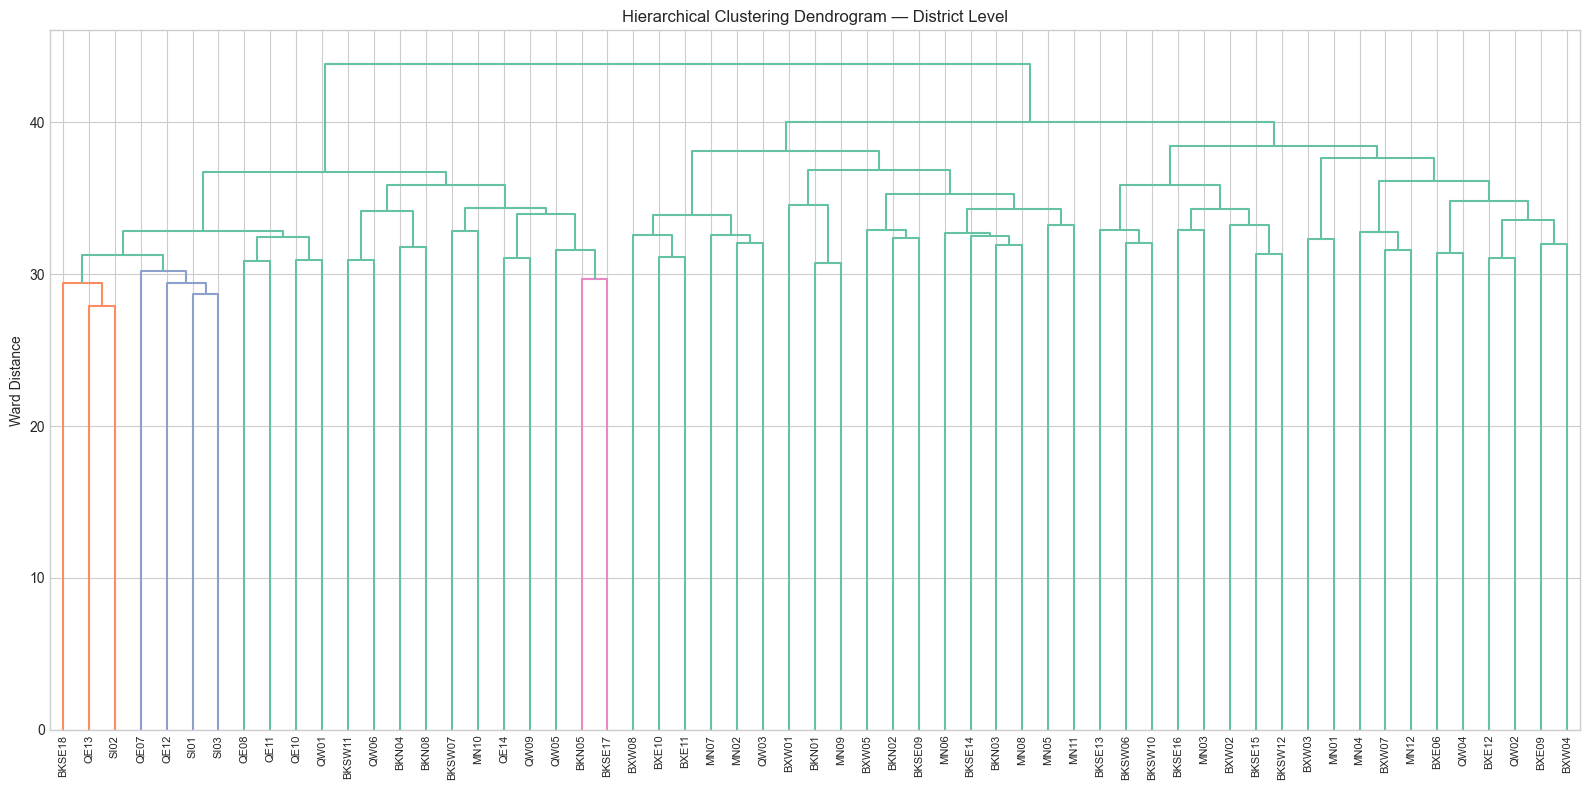

In [8]:
linkage_path = RESULTS_DIR / 'linkage_district.npy'
if linkage_path.exists():
    Z = np.load(linkage_path)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    dendrogram(Z, labels=ids_dist, leaf_rotation=90, leaf_font_size=8, ax=ax)
    ax.set_title('Hierarchical Clustering Dendrogram — District Level')
    ax.set_ylabel('Ward Distance')
    plt.tight_layout()
    plt.show()
else:
    print('No linkage matrix found — run clustering first')

## 6. Method Agreement

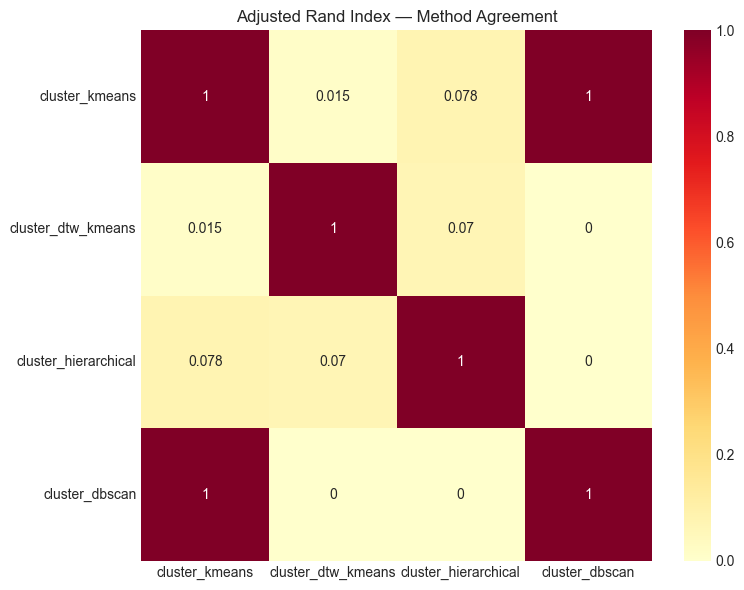

In [9]:
# How often do methods agree on grouping?
from sklearn.metrics import adjusted_rand_score

cluster_cols = [c for c in dist_assign.columns if c.startswith('cluster_')]
ari_matrix = pd.DataFrame(index=cluster_cols, columns=cluster_cols, dtype=float)

for i, c1 in enumerate(cluster_cols):
    for j, c2 in enumerate(cluster_cols):
        mask = (dist_assign[c1] != -1) & (dist_assign[c2] != -1)  # exclude noise
        if mask.sum() > 0:
            ari_matrix.loc[c1, c2] = adjusted_rand_score(
                dist_assign.loc[mask, c1], dist_assign.loc[mask, c2]
            )

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(ari_matrix.astype(float), annot=True, cmap='YlOrRd', vmin=0, vmax=1, ax=ax)
ax.set_title('Adjusted Rand Index — Method Agreement')
plt.tight_layout()
plt.show()